In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import wandb
import gpflow
from gpflow.likelihoods import Gaussian
from gpflow.base import Parameter

from markovflow.models.cvi_sde import SDESSM
from markovflow.sde.sde import PriorDoubleWellSDE

from docs.sde.sde_exp_utils import predict_ssm, plot_posterior

2022-08-22 10:40:53.965727: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 10:40:53.965766: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-22 10:40:56.698186: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-22 10:40:56.699388: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-22 10:40:56.722374: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-22 10:40:56.722410: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: verma
2022-08-22 10:40:56.722421: I tensorflow/stream_execut

In [2]:
seed_id = 18
main_dir = r"../data/" + str(seed_id)
sub_dir = "inference_0.001"
dt = 0.001

In [3]:
os.environ['WANDB_MODE'] = 'offline'
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


## Load Data

In [4]:
data_path = os.path.join(main_dir, "data.npz")
data = np.load(data_path)

In [5]:
DTYPE = gpflow.config.default_float()
NOISE_VAR = data["noise_stddev"]**2
Q = data["q"]
OBSERVATION_DATA = (data["observation_grid"].reshape((-1,)), data["observation_vals"].reshape((-1, 1)))
TIME_GRID = data["time_grid"]
T0 = TIME_GRID[0]
T1 = TIME_GRID[-1]

In [6]:
if dt != (TIME_GRID[1] - TIME_GRID[0]):
    TIME_GRID = tf.cast(np.linspace(T0, T1, int((T1-T0)//dt) + 2), dtype=DTYPE).numpy()

In [7]:
def load_tvgp(model_dir: str):
    
    true_q = Q * tf.ones((1, 1), dtype=DTYPE)
    prior_sde = PriorDoubleWellSDE(q=true_q, initial_a_val=3.1, initial_c_val=1.0)
    likelihood = Gaussian(NOISE_VAR)

    tvgp_model = SDESSM(input_data=OBSERVATION_DATA, prior_sde=prior_sde, grid=TIME_GRID,
                                   likelihood=likelihood, learning_rate=0.8)
    # Load trained model variables
    data_sites = np.load(os.path.join(model_dir, "ssm_data_sites.npz"))
    tvgp_model.data_sites.nat1 = Parameter(data_sites["nat1"])
    tvgp_model.data_sites.nat2 = Parameter(data_sites["nat2"])
    tvgp_model.data_sites.log_norm = Parameter(data_sites["log_norm"])

    sites = np.load(os.path.join(model_dir, "ssm_sites.npz"))
    tvgp_model.sites_nat1 = sites["nat1"]
    tvgp_model.sites_nat2 = sites["nat2"]

#     ssm_learning_path = os.path.join(model_dir, "ssm_learnt_sde.npz")
#     ssm_learning = np.load(ssm_learning_path)
#     tvgp_model.prior_sde.a = ssm_learning["a"] * tf.ones_like(tvgp_model.prior_sde.a)
#     tvgp_model.prior_sde.c = ssm_learning["c"] * tf.ones_like(tvgp_model.prior_sde.c)
    
    lin_path = os.path.join(model_dir, "ssm_linearization_path.npz")
    lin = np.load(lin_path)
    
    tvgp_model.initial_mean = OBSERVATION_DATA[1][0] + 0. * tvgp_model.initial_mean
    tvgp_model.initial_chol_cov = 0.5**(1/2) + 0. * tvgp_model.initial_chol_cov
    
    tvgp_model.linearization_pnts = (
                                     lin["fx_mus"].reshape(tvgp_model.fx_mus[:, :-1, :].shape), 
                                     lin["fx_covs"].reshape(tvgp_model.fx_covs[:, :-1, :, :].shape)
    )

    tvgp_model._linearize_prior()
    
#     lin_inf_path = os.path.join(model_dir, "ssm_latent_inference.npz")
#     lin_inf = np.load(lin_inf_path)
#     tvgp_model.fx_mus, tvgp_model.fx_covs = lin_inf["fx_mus"], lin_inf["fx_covs"]
    tvgp_model.fx_mus, tvgp_model.fx_covs = tvgp_model.dist_q.marginals
    
    return tvgp_model

## Load Model

In [8]:
t_vgp_model = load_tvgp(os.path.join(main_dir, sub_dir))

In [9]:
t_vgp_model.classic_elbo()

<tf.Tensor: shape=(), dtype=float64, numpy=-23.963912957065737>

In [10]:
np.load(os.path.join(main_dir, sub_dir, "ssm_elbo.npz"))["elbo"][-1]

-23.965317984897286

In [11]:
# lin_inf_path = os.path.join(main_dir, sub_dir, "ssm_latent_inference.npz")
# lin_inf = np.load(lin_inf_path)

# t_vgp_model.dist_q.marginal_means, lin_inf["fx_mus"]

In [12]:
# t_vgp_model.dist_q.marginal_covariances, lin_inf["fx_covs"]

## Plotting

In [13]:
prior_ssm = t_vgp_model.dist_p_ssm
prior_ssm_m = prior_ssm.marginal_means.numpy().reshape(-1)

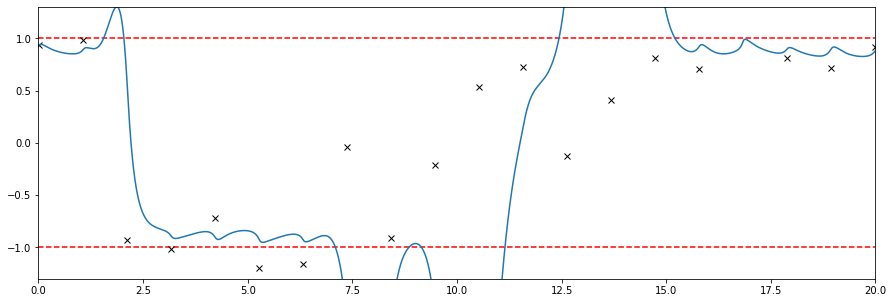

In [14]:
plt.subplots(1, 1, figsize=(15, 5))

plt.plot(OBSERVATION_DATA[0], OBSERVATION_DATA[1], "kx")
plt.plot(TIME_GRID, prior_ssm_m)
plt.hlines(-1, T0, T1, color="red", linestyle="dashed")
plt.hlines(1, T0, T1, color="red", linestyle="dashed")

plt.ylim([-1.3, 1.3])
plt.xlim([T0, T1])
plt.show()

## Plotting c = -b/A

In [ ]:
b = t_vgp_model.dist_p_ssm.state_offsets/dt
A = (t_vgp_model.dist_p_ssm.state_transitions - tf.eye(1, dtype=t_vgp_model.dist_p_ssm.state_transitions.dtype))/dt

A = tf.reshape(A, (-1))
b = tf.reshape(b, (-1))

c_tvgp = -b/A

In [ ]:
plt.subplots(1, 1, figsize=(15, 5))

plt.hlines(-1, T0, T1, color="red", linestyle="dashed")
plt.hlines(1, T0, T1, color="red", linestyle="dashed")

plt.plot(TIME_GRID[:-1], c_tvgp)
plt.ylim([-1.2, 1.2])
plt.xlim([T0, T1])
plt.title("-b/A")
plt.show()

### Posterior

In [ ]:
m_ssm, s_std_ssm = predict_ssm(t_vgp_model, tf.math.sqrt(NOISE_VAR))

In [ ]:
tvgp_pos = np.load(os.path.join(main_dir, sub_dir, "ssm_inference.npz"))

In [ ]:
plt.subplots(1, 1, figsize=(15, 5))

plt.plot(OBSERVATION_DATA[0], OBSERVATION_DATA[1], "kx")
plt.plot(TIME_GRID, prior_ssm_m)
plot_posterior(m_ssm, s_std_ssm, TIME_GRID, "SDE-SSM")
plt.plot(TIME_GRID, tvgp_pos["m"], alpha=0.4)

plt.xlim([T0, T1])
plt.ylim([-1.3, 1.3])

In [ ]:
OBSERVATION_DATA[1]/NOISE_VAR - t_vgp_model.data_sites.nat1.numpy()

In [ ]:
-1/(2*NOISE_VAR) - t_vgp_model.data_sites.nat2

## VGP Model Plot

### Variational Parameters

In [ ]:
lagrange_path = os.path.join(main_dir, sub_dir, "vgp_lagrange.npz")
lagrange_data = np.load(lagrange_path)

psi_lagrange = lagrange_data["psi_lagrange"]
lambda_lagrange = lagrange_data["lambda_lagrange"]

In [ ]:
A_b_path = os.path.join(main_dir, sub_dir, "vgp_A_b.npz")
A_b_data = np.load(A_b_path)

A = A_b_data["A"]
b = A_b_data["b"]

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15))

axs[0].plot(TIME_GRID, psi_lagrange.reshape(-1))
axs[0].set_title("Psi")

axs[1].plot(TIME_GRID, lambda_lagrange.reshape(-1))
axs[1].set_title("Lambda")
# axs[1].set_ylim(-1 , 1)

axs[2].plot(TIME_GRID, A.reshape(-1))
axs[2].set_title("A")

axs[3].plot(TIME_GRID, b.reshape(-1))
axs[3].set_title("b")
# axs[3].set_ylim(-2 , 2)

plt.show()


In [ ]:
c_vgp = b.reshape(-1)/A.reshape(-1)

In [ ]:
plt.subplots(1, 1, figsize=(15, 5))

plt.hlines(-1, T0, T1, color="red", linestyle="dashed")
plt.hlines(1, T0, T1, color="red", linestyle="dashed")

plt.plot(TIME_GRID, c_vgp, label="VGP")
plt.plot(TIME_GRID[:-1], c_tvgp, label="t-VGP")
plt.ylim([-1.2, 1.2])
plt.xlim([T0, T1])
plt.title("-b/A")
plt.legend()
plt.show()